## Voorspelling watertemperatuur bij reservoirs

### Eerste resultaten 

#### Doel

Doel van de tot op heden uitgevoerde analyses is het voorspellen van de temperatuur van het water ter plaatse van de inlaatstations naar de stad Amsterdam. 

#### Data

De relevante in- en uitvoerdata is beschikbaar gekomen via het benaderen van de PIMS database voor de volgende sensoren;

| tag | locatie | omschrijving |
|------|------|------|
| 1N305KM01TIT001 |  Nieuwegein Inname - Ruwwater |	Inname Lekkanaal |
| 1N625SW03TT001  |  Nieuwegein Snelfiltratie WRK I (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N625SW02TT001  |  Nieuwegein Snelfiltratie WRK II (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N315KM01TIT001 | Nieuwegein Transport - WRK I Filtraat | WBC na snelfiltratie |
| 1N315KM02TIT003 | Nieuwegein Transport - WRK II Filtraat | WBC na snelfiltratie |
| | | |
| 1Q325TB03TT151  | MIS Transport - WRK water Nieuwerkerkerstraat Lijnden | aftakking WRK II naar Havengebied |
| 1D325TA01TT001  | MIS Transport - WRK water Vogelenzang | Precieze locatie onbekend |
| T-WRK-Schiphol_STUW12 | MIS Transport WRK water stuw 12 | AWD voor infiltratie |
| | | |
| 1L635KM05TT002  | LDN Hardheidsreductie - onthard water afvoer West | Leiduin na ontharding |
| 1L635KM05TT001  | LDN Hardheidsreductie - onthard water afvoer Oost | Leiduin na ontharding |
| 1L315KM01TT001  | LDN Transport - Leiduin I Drinkwater | Leiduin drinkwater af pomp |
| | | |
| 3H325WT01TT001  | HLW Distributie - Haarlemmerweg Drinkwater | Pompstation Haarlemmerweg |
| 3A415DR01_Temp1 | AVW Drinkwaterreservoir 5 Ingaand HV085 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp2 | AVW Drinkwaterreservoir 5 Ingaand HV086 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp3 | AVW Drinkwaterreservoir 5 Uitgaand HV054 | Pompstation Amstelveenseweg na reservoir 5 |
| 3A415DR01_Temp4 | AVW Drinkwaterreservoir 1 Ingaand HV061 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp5 | AVW Drinkwaterreservoir 1 Ingaand HV062 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp6 | AVW Drinkwaterreservoir 1 Uitgaand HV038 | Pompstation Amstelveenseweg na reservoir 1 |

Het betreft hier **gemiddelde dagwaarden** voor de periode van 01-01-2015 tot heden.

Als we de gegevens plotten ziet het er als volgt uit;

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data
from fbprophet import Prophet
import datetime

%matplotlib inline

#### Meetdata Nieuwegein

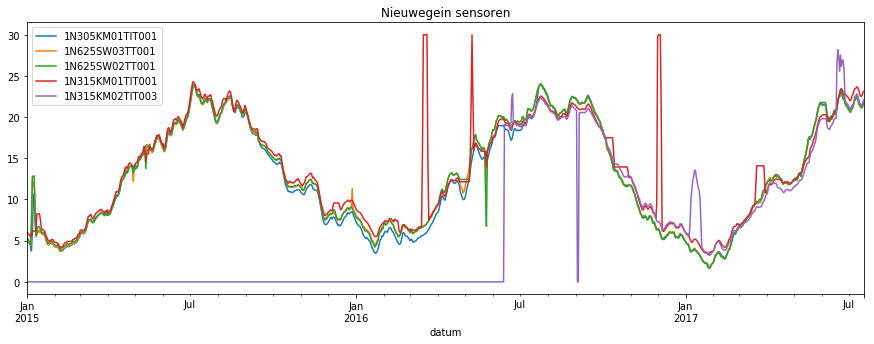

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M:%S')
df = pd.read_csv('data/combined_data.csv', parse_dates=[1], date_parser=dateparser)
df = df.reset_index()
_ = df.plot(x='datum', y=data.TAGS_NIEUWEGEIN[:], figsize=(15,5), title='Nieuwegein sensoren')

#### Meetdata Leiduin

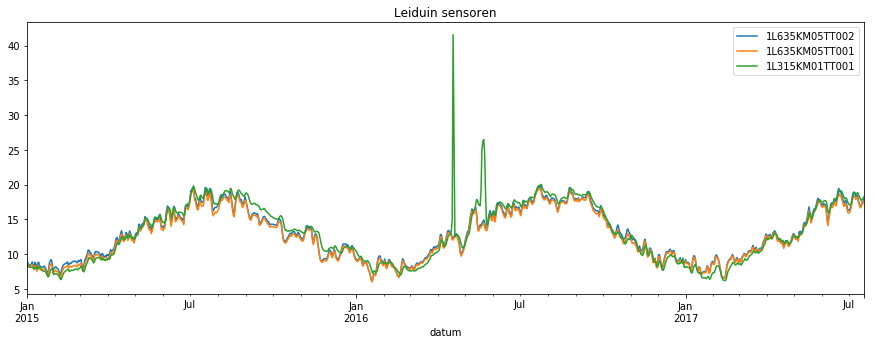

In [3]:
_ = df.plot(x='datum', y=data.TAGS_LEIDUIN[:], figsize=(15,5), title='Leiduin sensoren')

#### Meetdata pompstations

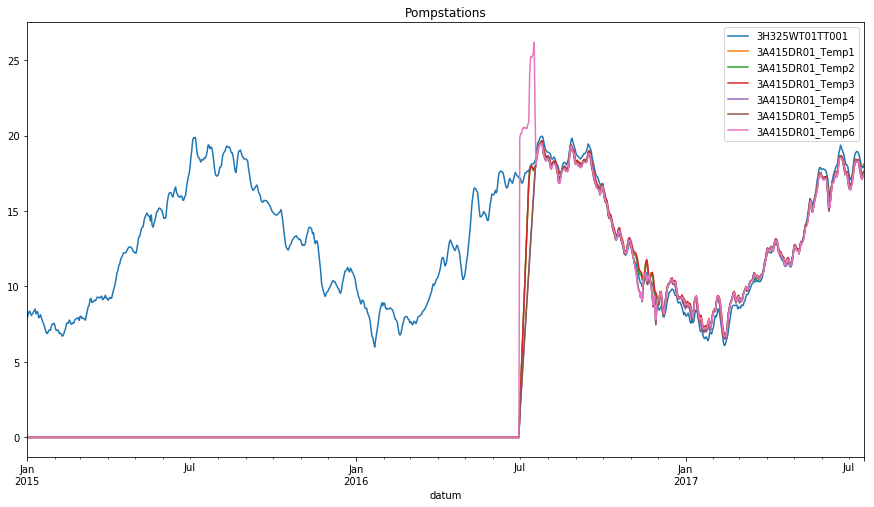

In [4]:
_ = df.plot(x='datum', y=data.TAGS_OUTPUT[:], figsize=(15,8), title='Pompstations')

Wat opvalt is dat er slechts voor 1 station (3H325WT01TT001, Haarlemmerweg) een langdurige meting beschikbaar is. Het goede nieuws is dat de overige meetdata vrijwel dezelfde lijn volgt en daarmee een voorspelling voor de Haarlemmerweg in een acceptabele bandbreedte valt voor de overige pompstations.

#### Vergelijking data inlaat- en uitlaatpunt

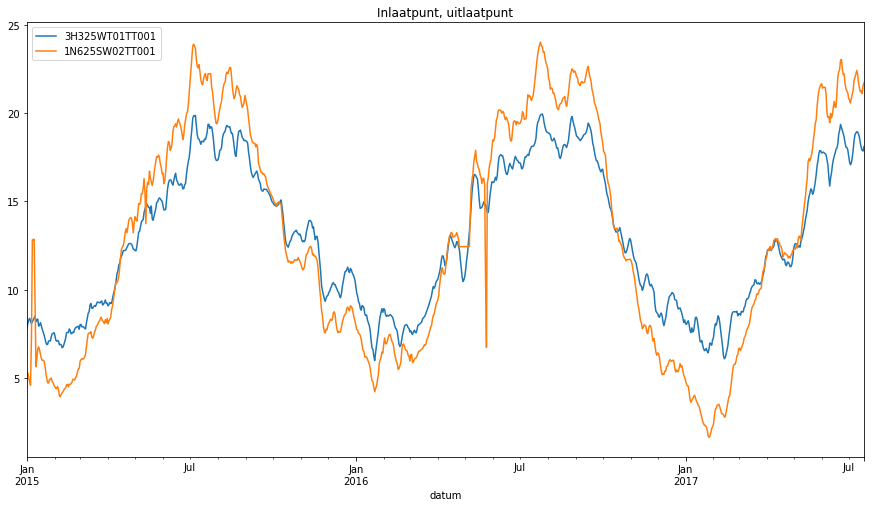

In [5]:
_ = df.plot(x='datum', y=['3H325WT01TT001', '1N625SW02TT001'], figsize=(15,8), title='Inlaatpunt, uitlaatpunt')

Er is een grote correlatie zit tussen de inlaat- en uitlaattemperatuur. Aangezien het water tussen inlaat- en uitlaatpunt een lange verblijftijd heeft is dit geen daadwerkelijke relatie maar heeft dit waarschijnlijk te maken met atmosferische omstandigheden. 

**HYPOTHESE** De temperatuur van het water bij het inlaat- en uitlaatpunt is sterk gecorreleerd aan de buitentemperatuur.

#### Voorspelling enkel op basis van de gemeten waarden bij het pompstation

De eerste uitgevoerde analyse kijkt enkel naar de meetwaarden van de sensor aan de Haarlemmerweg. We gebruiken hiervoor de tijdreeks software fbprophet waarbij we 4 weken vooruit willen kijken.

Via een iteratieve methode hebben we voor het model de volgende parameters vastgesteld;
* changepoint_prior_scale=0.1, 0.05 (default) of 0.001 (waardoor het effect van de voorspelling scherper of vlakker wordt)

We gebruiken de volgende methode;
* train het model met data vanaf 1-1-2015 tot x weken voor het aangenomende einde van de meetreeks
* voorspel 8 weken dagen vooruit 
* check de voorspelling van de eerste x weken met de werkelijk gemeten waarden 

Belangrijke voorspelmomenten zijn de toppen van de grafiek waardoor we de controle uitvoeren op de periodes
* juli 2016
* augustus 2016
* juli 2017

In [7]:
VOORSPELLINGSPERIODE = 28 #dagen
# bepaal de rij nummers van 1 juli en 1 augustus 2016
idx_juli_2016 = df[df['datum']=='2016-07-01'].index.tolist()[0]
idx_aug_2016 = df[df['datum']=='2016-08-01'].index.tolist()[0]
idx_juli_2017 = df[df['datum']=='2017-07-01'].index.tolist()[0]

def doe_voorspelling(t1, dt, cpps=0.05):
    df_hw = pd.DataFrame()
    df_hw['ds'] = df['datum'][:t1]
    df_hw['y'] = np.log(df['3H325WT01TT001'][:t1])
    model_1 = Prophet(interval_width=0.95, yearly_seasonality=True, changepoint_prior_scale=cpps)
    model_2 = Prophet(interval_width=0.95, yearly_seasonality=True, changepoint_prior_scale=0.1)
    model_3 = Prophet(interval_width=0.95, yearly_seasonality=True, changepoint_prior_scale=0.001)
    
    model_1.fit(df_hw)
    model_2.fit(df_hw)
    model_3.fit(df_hw)
    
    future_1 = model_1.make_future_dataframe(periods=dt)
    #future_2 = model_2.make_future_dataframe(periods=dt)
    #future_3 = model_3.make_future_dataframe(periods=dt)
    forecast_1 = model_1.predict(future_1)
    forecast_2 = model_2.predict(future_1)
    forecast_3 = model_3.predict(future_1)
    _ = model_1.plot(forecast_1)  
    
    X = df['datum'][t1:t1+dt]
    y_test = df['3H325WT01TT001'][t1:t1+dt]
    y_pred_1 = np.exp(forecast_1['yhat'][t1:t1+dt])
    y_pred_1_lower = np.exp(forecast_1['yhat_lower'][t1:t1+dt])
    y_pred_1_upper = np.exp(forecast_1['yhat_upper'][t1:t1+dt])
    y_pred_2 = np.exp(forecast_2['yhat'][t1:t1+dt])
    y_pred_2_lower = np.exp(forecast_2['yhat_lower'][t1:t1+dt])
    y_pred_2_upper = np.exp(forecast_2['yhat_upper'][t1:t1+dt])
    y_pred_3 = np.exp(forecast_3['yhat'][t1:t1+dt])
    y_pred_3_lower = np.exp(forecast_3['yhat_lower'][t1:t1+dt])
    y_pred_3_upper = np.exp(forecast_3['yhat_upper'][t1:t1+dt])
    plt.figure(figsize=(15,5))
    plt.plot(X, y_test, label='test data')
    plt.plot(X, y_pred_1, label='voorspelling')
    plt.plot(X, y_pred_1_lower, '--', label='voorspelling ondergrens')
    plt.plot(X, y_pred_1_upper, '--', label='voorspelling bovengrens')
    plt.plot(X, y_pred_2, label='voorspelling cpps=0.1')
    plt.plot(X, y_pred_3, label='voorspelling cpps=0.001')
    #plt.plot(X, y_pred_1_lower, '--', label='voorspelling ondergrens')
    #plt.plot(X, y_pred_1_upper, '--', label='voorspelling bovengrens')
    plt.legend()

#### Juli 2016 voorspelling

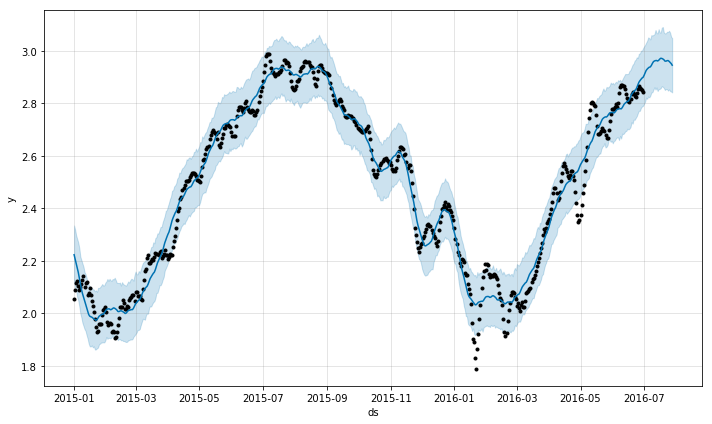

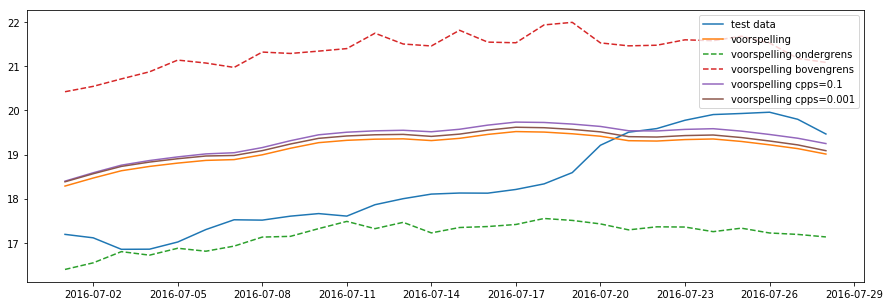

In [8]:
doe_voorspelling(idx_juli_2016, VOORSPELLINGSPERIODE)

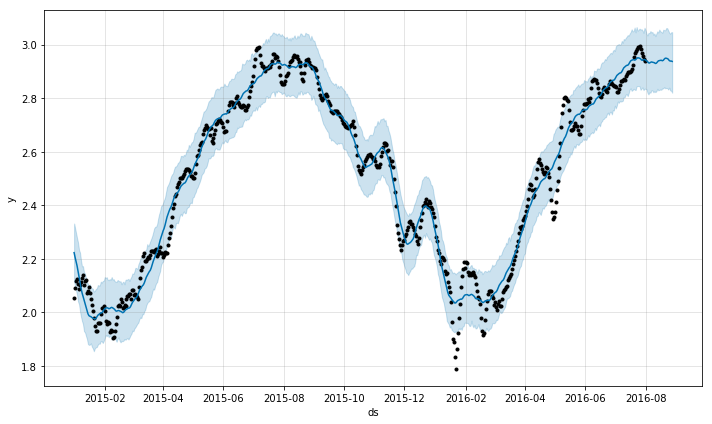

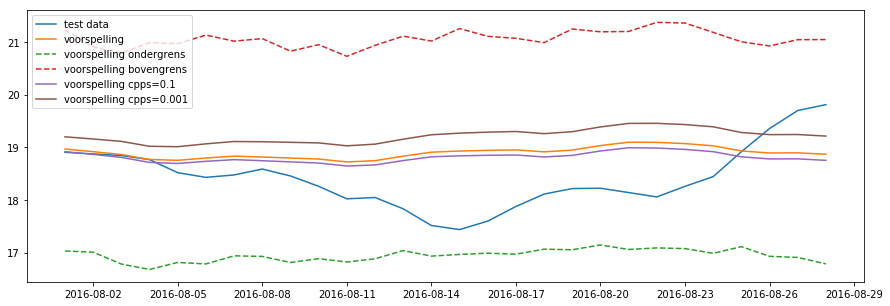

In [9]:
doe_voorspelling(idx_aug_2016, VOORSPELLINGSPERIODE)

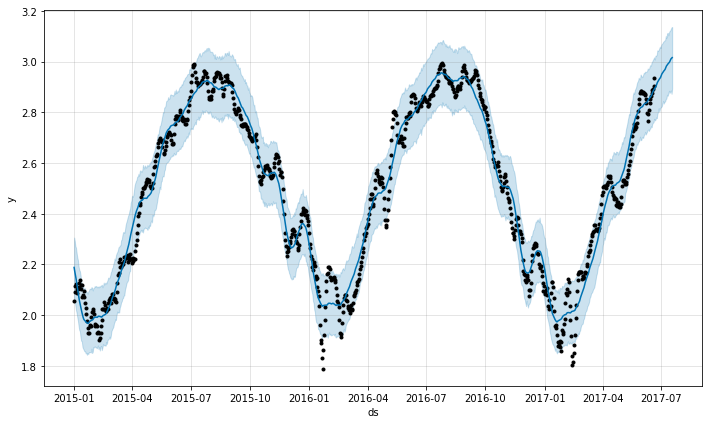

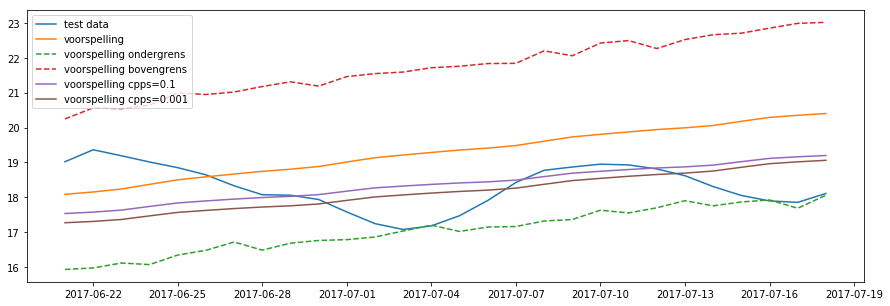

In [10]:
doe_voorspelling(idx_juli_2017-10, VOORSPELLINGSPERIODE) #-10 omdat we 10 dagen missen

#### Conclusie voorspellen op enkel de sensordata

Het gebruik van FBProphet op puur de invoer data en met een vooruitblik van 4 weken tijd geeft hele redelijke resultaten. Als we naar de voorspelling van juli 2016 kijken dan ligt de voorspelde temperatuur in het begin rond de 1.5 graden onder de werkelijke temperatuur. De maximale overschrijding van de gemeten temperatuur bedraagt een acceptabele 0.5 graden.

Voor augustus 2016 ligt de gemeten temperatuur over het algemeen ook tot maximaal 1.5 graden onder de werkelijke temperatuur. De maximale overschrijding van de gemeten temperatuur bedraagt 0.5 graden.

Voor juli 2017 is een maximale overschrijding gevonden van ruim 1 graad. Hier is ook duidelijk dat de voorspelling voor de bovengrens het beste presteert als de factor cpps op 0.05 wordt gehouden. 

**Conclusies FBProphet model**
* De voorspellingen zijn nauwkeurig tot op +1.5 en -1.5 graden tov de gemeten waarden
* De werkelijke gemeten waarde is met maximaal van 1 graad hoger geweest dan de voorspelde waarde
* De factor cpps kan het beste op 0.05 worden gehouden
* De gemeten waarden vallen in alle testcases binnen de onder- en bovengrens van de voorspelling (ca -2 tot +2.5)
* Het model is zeer eenvoudig te bouwen
* Een doorrekening van het model in een ongeoptimaliseerde Jupyter omgeving kost rond de 1-2sec rekentijd (i7-3770CPU @ 3.40GHz)